In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
import os
import sys
import math
import time

import numpy as np
import scipy as sp
import cv2

from IPython.display import display
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from daugman import find_iris

import mediapipe as mp
facemesh = mp.solutions.face_mesh

from segment import segment

from lbp2 import ScikitBinaryPattern, Features
from skimage.feature import local_binary_pattern as lbp_scikit

In [78]:
# 1. FIND SOME EYE PICTURES [x]

# 2. FIND AND TEST AND IRIS DETECTOR(S)

    # https://pypi.org/project/G6-iris-recognition/   -> traditional iris recognition
    # https://pypi.org/project/aiocv/, https://pypi.org/project/cv2utils/   -> eye detectors among other things

    # https://pypi.org/project/irisSeg/   -> very simple traditional iris detector (REQUIRES OLD SCIPY AND PYTHON)
    # https://github.com/thuyngch/Iris-Recognition
    # NN options:
    # https://github.com/CVRL/iris-recognition-OTS-DNN
    # https://lmi.fe.uni-lj.si/wp-content/uploads/2019/08/IWOBI_2018_paper_15.pdf
    # https://github.com/Asadullah-Dal17/iris-Segmentation-mediapipe-python
    
    #https://google.github.io/mediapipe/solutions/iris.html
    # https://github.com/banderlog/daugman/blob/master/daugman.py


face mesh detected


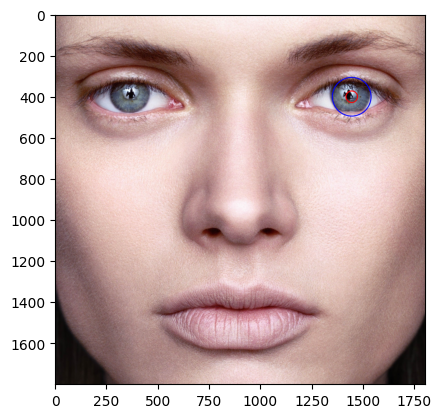

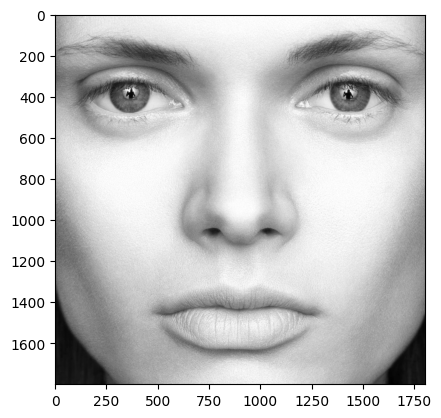

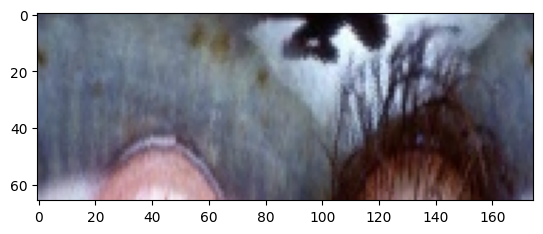

In [15]:
# ------- UTILITIES --------

def load_img(pth, crop_square=True):
    img = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    if crop_square:
        a = np.min(img.shape[:2])
        sty, stx = ((img.shape[:2]-a) / 2).astype(int)
        img = img[sty:sty+a, stx:stx+a, :]
    return img

def show_iris_seg(img, pupcenter, puprad, ircenter, irrad):
    out = img.copy()
    ircenter = pupcenter
    cv2.circle(out, ircenter, irrad, (0, 0, 255), 4)
    cv2.circle(out, pupcenter, puprad, (255, 0, 0), 4)
    plt.imshow(out)
    plt.show()
    
def get_iris_mask(img, pupc, puprad, irc, irrad):
    
    mask = np.zeros_like(img)
    irmask = cv2.circle(mask.copy(), irc, irrad, (255, 255, 255), -1)
    pupmask = cv2.circle(mask.copy(), pupc, puprad, (255, 255, 255), -1)
    mask = cv2.subtract(irmask, pupmask)
    
    return mask

def unwrap_iris(img, center, puprad, irrad):
    
    w = irrad - puprad
    steps = int(2 * math.pi * puprad)
    
    out = np.zeros((w, steps, 3))
    
    for i in range(steps):
        for j in range(w):
            angle = 2*math.pi * (i/steps)
            r = puprad + j - 1
            y = center[1] + int(r*math.sin(angle))
            x = center[0] + int(r*math.cos(angle))
            out[j, i, :] = img[y, x, :]
    
    return out.astype(np.uint8)

    
    
# ------- SEGMENTATION ALGORITHMS (find the iris region) --------

def seg_iris_daugman(square_img, resize=200):
    """Daugman iris segmentation algoritm"""
    
    # SLOW AND UNRELIABLE atm !!!
    
    imgsmall = square_img
    if resize is not None:
        RATIO = img.shape[0] / resize
        imgsmall = cv2.resize(img, (resize, resize))

    gray = cv2.cvtColor(imgsmall, cv2.COLOR_RGB2GRAY)
    
    minr, maxr = int(0.15*gray.shape[0]), int(0.5*gray.shape[0])
    points_step = int(gray.shape[0] / 100)
    dg_step = max(1, int(points_step / 2))
    
    #print(minr, maxr, points_step, dg_step)
    
    ircenter, irrad = find_iris(gray, daugman_start=minr, daugman_end=maxr, daugman_step=dg_step, points_step=points_step)
    pupcenter, puprad = find_iris(gray, daugman_start=5, daugman_end=irrad, daugman_step=dg_step, points_step=points_step)
    
    if resize is not None:
        ircenter = (int(ircenter[0]*RATIO), int(ircenter[1]*RATIO))
        pupcenter = (int(pupcenter[0]*RATIO), int(pupcenter[1]*RATIO))
        irrad = int(irrad*RATIO); puprad = int(puprad*RATIO)

    return pupcenter, puprad, ircenter, irrad, square_img



LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [429, 470, 471, 472]

def seg_iris_mediapipe(img):
    """Segmentation with Google's mediapipe stack"""
    
    # FAST AND RELIABLE
    # BUT ONLY WORKS IF ENTIRE FACE IS SEEN

    w, h = img.shape[:2]
    
    with facemesh.FaceMesh(max_num_faces=1,
                            refine_landmarks=True,
                            min_detection_confidence=0.5,
                            min_tracking_confidence=0.5) as fm:
        results = fm.process(img)
        if results.multi_face_landmarks:
            print("face mesh detected")
            lms = results.multi_face_landmarks
            meshpoints = np.array([np.multiply([p.x, p.y] , [w, h]).astype(int) for p in lms[0].landmark])
            
            left_iris = meshpoints[LEFT_IRIS]
            right_iris = meshpoints[RIGHT_IRIS]
            
            
            #img = cv2.polylines(img, [left_iris], True, (255, 0, 0), 1, cv2.LINE_AA)
            
            center = np.mean(left_iris, axis=0)
            rad = np.mean(np.linalg.norm(left_iris - center, axis=1))
            center = center.astype(int)
            irrad = int(rad)
            
            puprad = int(0.3 * irrad)
            
            #img = cv2.circle(img, center, irrad, (0, 255, 0), 3)
        
        #figsize(6, 6)
        #plt.imshow(img)
        
        return center, puprad, center, irrad, img
    


def seg_iris_thuy(img, resize=None):
    """Another Daugman detector implementation"""
    
    imgsmall = img
    if resize is not None:
        RATIO = img.shape[0] / resize
        imgsmall = cv2.resize(img, (resize, resize))
    
    img_gray = cv2.cvtColor(imgsmall, cv2.COLOR_RGB2GRAY)
    
    iris, pupil, img_masked = segment(img_gray, eyelashes_thres=10, use_multiprocess=False)
    irx, iry, irrad = iris
    pupx, pupy, puprad = pupil
    pupcenter, ircenter = (pupy, pupx), (iry, irx)
    
    if resize is not None:
        ircenter = (int(ircenter[0]*RATIO), int(ircenter[1]*RATIO))
        pupcenter = (int(pupcenter[0]*RATIO), int(pupcenter[1]*RATIO))
        irrad = int(irrad*RATIO); puprad = int(puprad*RATIO)
        img_masked = cv2.resize(img_masked, (img.shape[1], img.shape[0]))
    
    return ircenter, puprad, pupcenter, irrad, img_masked


img = load_img("face.jpg", crop_square=True)

pupcenter, puprad, ircenter, irrad, _img = seg_iris_mediapipe(img)
#pupcenter, puprad, ircenter, irrad, _img  = seg_iris_daugman(img)
#pupcenter, puprad, ircenter, irrad, _img  = seg_iris_thuy(img, resize=200)
mask = np.isnan( np.repeat(_img[:, :, np.newaxis], 3, axis=2) )
#img[mask] = 0 # should be a float array with NaNs in the future


show_iris_seg(img, pupcenter, puprad, ircenter, irrad)
plt.imshow(img[:, :, 0], cmap="gray")
plt.show()
unwrapped = unwrap_iris(img, pupcenter, puprad, irrad)
plt.imshow(unwrapped)







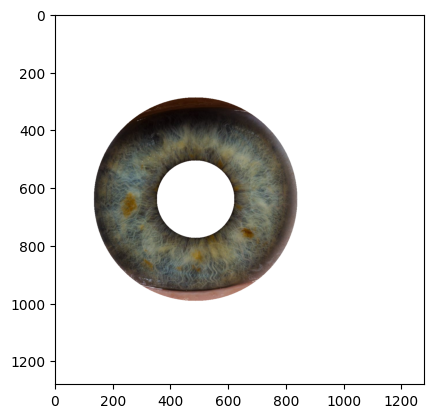

(486, 640) 134 352


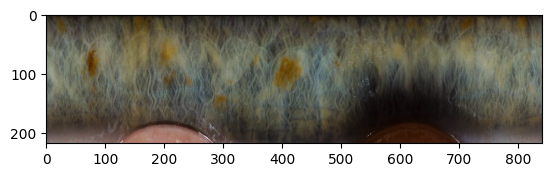

In [18]:
# DEMONSTRATE SEGMENTATION

mask = get_iris_mask(img, pupcenter, puprad, ircenter, irrad)
masked = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
masked[:, :, 3] = mask[:, :, 0]
plt.imshow(masked)
plt.show()

print(pupcenter, puprad, irrad)
unwrapped = unwrap_iris(img, pupcenter, puprad, irrad)
plt.imshow(unwrapped)
        

In [18]:
# ------- FEATURE EXTRACTION AND MATCHING METHODS ---------


from sentence_transformers import SentenceTransformer
from PIL import Image

def _get_histogram(ft_img, d, row, col, cell_size):
    """Compute LBP histogram for one cell"""
    
    cell = ft_img[row:row+cell_size, col:col+cell_size]
    hist = np.zeros(d).astype(int)

    unique, counts = np.unique(cell, return_counts=True)
    #print(unique)
    #print(counts)
    unique = unique.astype(int)
    hist[unique] = counts
    
    #print(cell[:10, :10])
    return hist

def _process_hists(ft_img, d, cell_size=16, mode="mean"):
    """Compute histogramed feature vector from a LBP image"""

    hist_list = []
    rows = int( ft_img.shape[0] / cell_size )
    cols = int( ft_img.shape[1] / cell_size )
    
    for i in range(rows):
        cell_row = i*cell_size

        for j in range(cols):
            cell_col = j*cell_size
            hist = _get_histogram(ft_img, d, cell_row, cell_col, cell_size)
            hist_list.append(hist)

    assert mode in ["mean", "concat"]
    if mode == "mean":
        features = np.mean(np.stack(hist_list, axis=0), axis=0)
    elif mode == "concat":
        features = np.concatenate(hist_list, axis=0)
    return features

def lbp_extractor(img, d=8*3, r=3, cell_size=32):
    """Extract Linear Binary Pattern (LBP) features from image"""
    
    if len(img.shape) > 2:
        img = img[:, :, 0]
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    ftimg = lbp_scikit(img, d, r, "uniform").astype(int)
    ft = _process_hists(ftimg, d+2, cell_size=cell_size, mode="mean")
    return ft


"""Extract features from an image with CLIP neural embedding"""
clip = SentenceTransformer("clip-ViT-B-32")
clip_extractor = lambda img: clip.encode(Image.fromarray(img))


def kl_divergence(p, q):
    """Compute KL-divergence between two feature vectors"""
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

"""Compute eucledian distance between two feature vectors"""
eucl_dist = lambda x, y: np.linalg.norm((x-y)**2)


In [9]:

# quick test


def match_pattern(q, pt_dir, resize=400,
                    extractor=lbp_extractor, 
                    dist_func=kl_divergence,
                    verbose=True):
    """Compare query image (iris) to images from pt_dir (patterns) in terms of extracted features.
        Find and return best matches.
    """
    
    fns, dists = [], []
    if verbose: print("Extracting query features..")
    q_ft = extractor(q)
    
    #print(len(q_ft), q_ft[:10])
    
    if verbose: print("Extracting database features...")
    for fn in os.listdir(pt_dir):
        fns.append(fn)
        pattern = load_img(os.path.join(pt_dir, fn), crop_square=False)
        if resize is not None: pattern = cv2.resize(pattern, (resize, resize))
        pattern_ft = extractor(pattern)
        #print(len(pattern_ft), pattern_ft[:10])
        dist = dist_func(q_ft, pattern_ft)
        dists.append(dist)
        if verbose: print(fn, dist)
        besti = np.argsort(dists)
        
    return fns, dists, besti
    
    
def show_matches(q, pt_dir, fns, dists, besti):
    """Display matching steps for one query image"""
    print(f"Best match = {fns[besti[0]]}")
    figsize(10,3)
    plt.imshow(q)
    plt.axis('off')
    plt.show()
    n = 3
    figsize(10,4)
    for i, bi in enumerate(besti[:n]):
        match = load_img(os.path.join(pt_dir, fns[bi]), crop_square=True)
        plt.subplot(1, n, i+1)
        plt.imshow(match)
        plt.axis('off')
    plt.show()
    
def show_matches_subfig(q, pt_dir, fns, dists, besti, k=3, q2=None):
    """Display matches in compact form"""
    if q2 is not None: k += 1
    figsize(12,3)
    plt.subplot(1, k+1, 1)
    q = q[:, :min(q.shape[0], q.shape[1])]
    plt.imshow(q)
    plt.axis('off')
    if q2 is not None:
            plt.subplot(1, k+1, 2)
            q2 = q2[:, :min(q.shape[0], q.shape[1])]
            plt.imshow(q2)
            plt.axis('off')
    for i, bi in enumerate(besti[:k-1]):
        match = load_img(os.path.join(pt_dir, fns[bi]), crop_square=True)
        plt.subplot(1, k+1, i+3)
        plt.imshow(match)
        plt.axis('off')
        
def show_matches_subfig2(q,pt_dir, fns, dists, besti):
    figsize(6,9)
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2, 3, figure=fig)
    ax = fig.add_subplot(gs[:, 0])
    q = q[:, :min(q.shape[0]*2, q.shape[1])]
    q = np.transpose(q, (1,0,2))
    ax.imshow(q)
    ax.axis('off')
    for i, bi in enumerate(besti[:4]):
        match = load_img(os.path.join(pt_dir, fns[bi]), crop_square=True)
        print(i+2+ (i//3))
        ax = fig.add_subplot(gs[(i//2)+1:, i%2])
        #plt.subplot(2, 3, i+2+ )
        ax.imshow(match)
        ax.axis('off')
    plt.tight_layout()
    

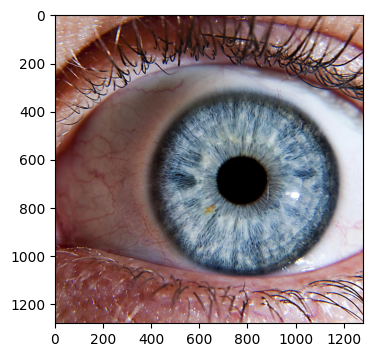

Segmenting iris...


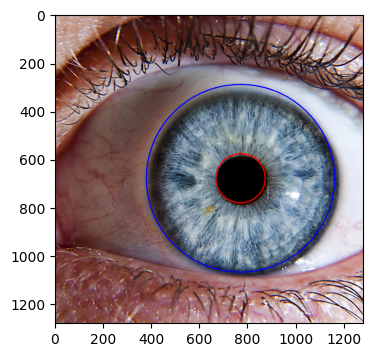

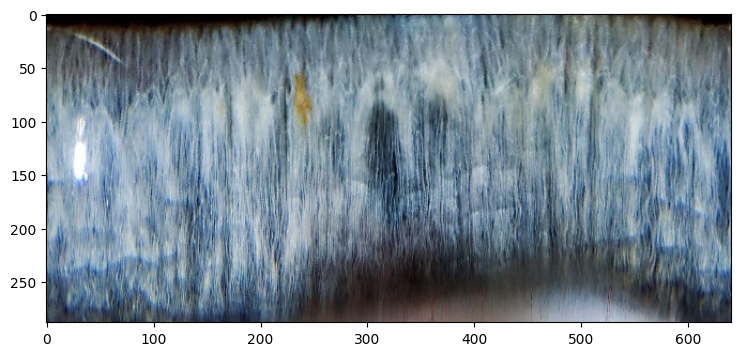

Extracting query features..
Extracting database features...
1.jpg 5.104069
10.jpg 4.449884
11.jpg 4.553227
12.jpg 5.2943025
13.jpg 6.8676124
14.jpg 6.0177584
15.jpg 8.270026
16.jpg 8.617336
17.jpg 10.144607
18.jpg 3.8534281
19.jpg 8.996174
2.jpg 5.741911
20.jpg 8.65902
21.jpg 6.5492773
22.jpg 6.1403155
23.jpg 4.249884
24.jpg 5.0416913
25.jpg 5.9751005
26.jpg 6.3959103
27.jpg 7.1838994
28.jpg 3.448139
29.jpg 3.9929128
3.jpg 3.993917
30.jpg 6.1395354
31.jpg 7.444569
32.jpg 4.0491567
33.jpg 4.1150737
34.jpg 7.965629
35.jpg 7.047982
36.jpg 6.163931
37.jpg 8.032025
4.png 8.517951
5.jpg 3.0125213
6.jpg 4.100932
7.jpg 4.6757493
8.jpg 5.393527
9.jpg 3.1892905
Best match = 5.jpg


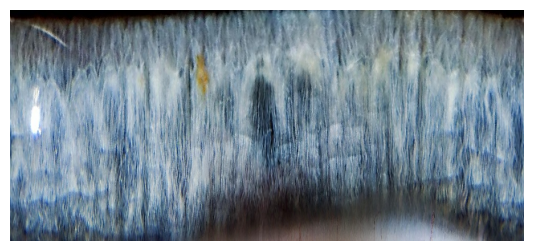

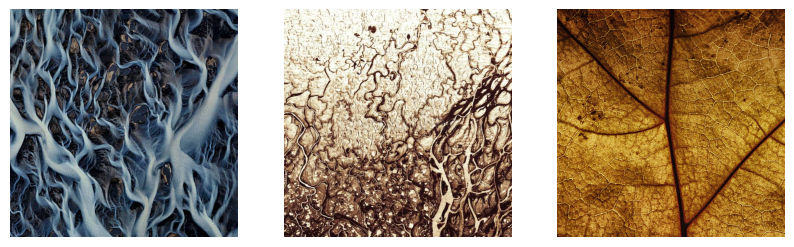

In [22]:

# --------------------
#     AN EXAMPLE
# --------------------


img = load_img("iris/3.jpg")
plt.imshow(img); plt.show()
print("Segmenting iris...")
pupcenter, puprad, ircenter, irrad, _  = seg_iris_daugman(img)
show_iris_seg(img, pupcenter, puprad, ircenter, irrad)

unwrapped = unwrap_iris(img, pupcenter, puprad, irrad)

plt.show(); plt.imshow(unwrapped); plt.show()

fns, dists, besti = match_pattern(unwrapped, "pattern", extractor=clip_extractor, dist_func=eucl_dist, resize=400)
show_matches(unwrapped, "pattern", fns, dists, besti)

In [5]:

# -------------------------------------------
#    BEST MATCHES FOR MULTIPLE QUERIES
# -------------------------------------------

FILES = [1, 2, 3, 4, 8, 9, 11]

for f in FILES:
    pth = f"iris/{f}.jpg"
    img = load_img(pth)
    pupcenter, puprad, ircenter, irrad, _  = seg_iris_daugman(img)
    unwrapped = unwrap_iris(img, pupcenter, puprad, irrad)
    #show_iris_seg(img, pupcenter, puprad, ircenter, irrad)
    fns, dists, besti = match_pattern(unwrapped, "pattern",
                                    extractor=lbp_extractor, dist_func=eucl_dist,
                                    verbose=False, resize=800)
    q2 = unwrapped; q2 = q2[:, :min(q2.shape[0], q2.shape[1])]
    show_matches_subfig(img, "pattern", fns, dists, besti, q2=q2)
    plt.show()

NameError: name 'match_pattern' is not defined

In [11]:
# THE LOOP


def capture_img():
    pass

def segment_iris(img):
    pass

def display_loading(img, iris, count):
    pass

class IrisProcess():
    
    def __init__(self):
        self.state = 0
        self.states = [
            self.state_idle,
            self.state_loading,
            self.state_processing,
            self.state_results
        ]
        
        # Used by all states
        self.cap = cv.VideoCapture(0)
        self.img = None
        self.meshpoints = []
        self.iris = {}
        self.time = 0 # since calling run() in seconds
        
        # Loading
        self.minrad = 200
        self.loaddur = 24 * 5
        self.loadcount = self.loaddur
        
        # Processing
        self.prdur = 24 * 10
        self.prcount = self.prdur
    
    def state_idle(self):
        """Default state. Capturing footage, segmenting iris."""
        
        # DISPLAY THE CAPTURE
        
        if self.iris["irrad"] > self.minrad:
            self.state = 1
            return
        
    def state_loading(self):
        """When iris is close enough. Count down until processing."""
        
        # DISPLAY CAPTURE + LOADING
        
        if self.loadcount <= 0:
            self.state = 2
            self.loadcount = self.loaddur
            return
        if self.iris["irrad"] < self.minrad:
            self.state = 0
            self.loadcount = self.loaddur
            return
        self.loadcount -= 1
        
    def state_processing(self):
        """After loading completes. Encode and match, visualize progress."""
        
        # UNROLL IRIS
        # LOAD PATTERNS
        # ENCODE IRIS AND PATTERNS
        # COMPUTE DISTANCES
        # FIND BEST MATCHES
        # DISPLAY ALL THIS 
        
        if self.prcount <= 0:
            self.state = 3
            self.prcount = self.prdur
        self.prcount -= 1
        
    def state_results(self):
        """After processing completes. Present matches."""
        
        # DISPLAY MATCHES
        # HAVE A DOWNLOAD BUTTON
        # HAVE A RESET BUTTON -> and reset state in callback
        pass
    
    def run(self):
        self.time = 0
        while(True):
            self.time = time.time()
            #self.img = capture_img()
            #self.iris, self.meshpoints = segment_iris(self.img)
            self.states[self.state]()
            elapsed = time.time() - self.time
            tosleep = max(1/24 - elapsed, 0)
            time.sleep(tosleep)
            
pr = IrisProcess()
pr.iris["irrad"] = 300
pr.run()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


KeyboardInterrupt: 